In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import xarray
import glob
import matplotlib.colors as colors
from matplotlib import cm
import palettable

### Eddy Flux Tower Data

In [2]:
path = '/jet/home/xjliu/work/DATA/Flux_Tower/'
data2 = pd.read_csv(path+'Control-Tha-Results.csv')
data = data2.sort_values(by='Datetime')
data = data.rename(columns={'m':'Month'})

data2 = pd.read_csv(path+'Soy-Tha-Results.csv')
data_crop = data2.sort_values(by='Datetime')
data_crop = data_crop.rename(columns={'m':'Month'})


/ocean/projects/atm200007p/xjliu/miniconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (174,306,314) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## Bootstraping method to estimate the mean of LE

In [3]:
def bootstrap_ci(df, variable, classes, repetitions = 1000, alpha = 0.05, random_state=None): 
    
    df = df[[variable,classes]]
    bootstrap_sample_size = len(df) 
    class_size = len(df[classes].unique())
    sample_mean = np.empty([class_size,1])
   
    for i in range(repetitions):
            bootstrap_sample = df.sample(n = bootstrap_sample_size, replace = True, random_state = random_state)
            avg = bootstrap_sample.groupby(classes).mean()
            sample_mean = np.hstack((sample_mean,avg))
            
    # confidence interval
    bounds = pd.DataFrame(index=np.arange(class_size),columns=['left','right'])
    right = np.empty([class_size,1])
    left = np.empty([class_size,1])

    for ii in range(class_size):
        left[ii] = np.percentile(sample_mean[ii,:], alpha/2*100)
        right[ii] = np.percentile(sample_mean[ii,:], 100-alpha/2*100)
    # point estimate
        point_est = df.groupby(classes).mean()
        #point_est = sample_mean.mean(1)
    bounds.left = left
    bounds.right = right
    #print('Point estimate of difference between means:', round(point_est,2))
    #print(round(bounds.left,2))
    #print((1-alpha)*100,'%','confidence interval for the difference between means:', (round(left,2), round(right,2)))

    return (point_est,bounds)


### Mean LE of all available years

In [6]:
data_crop.Year.unique()

array([2015, 2016, 2017, 2018, 2019, 2020])

NameError: name 'LH_JJA_forest_areamean' is not defined

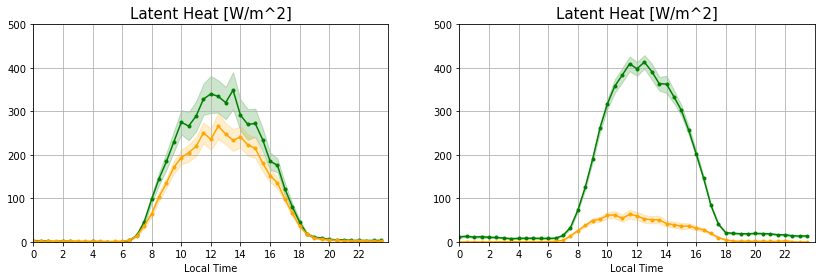

In [4]:
month_sel = [[12,1,2],[6,7,8]]
colors=['g','g']

labels=['(a) Wet Season (DJF)','(b) Dry Season (JJA)']
fig,axes = plt.subplots(1,2,figsize=(14,4),sharex=True)
axes = axes.ravel()
for ii in range(2):
    forest = data[(data.Month.isin(month_sel[ii]))]# & (data.Year.isin(np.arange(2014,2016)))]
    crop = data_crop[(data_crop.Month.isin(month_sel[ii]))]# & (data_crop.Year.isin(np.arange(2014,2016)))]

    forest_mn,forest_CI = bootstrap_ci(forest,'LE','Hour')
    crop_mn,crop_CI = bootstrap_ci(crop,'LE','Hour')

    axes[ii].plot(np.arange(0,24,0.5),forest_mn,'-',color=colors[ii],
                 label='Forest')
    axes[ii].plot(np.arange(0,24,0.5),forest_mn,'.',color=colors[ii],
                 label='Forest')
    axes[ii].fill_between(np.arange(0,24,0.5),forest_CI.left,forest_CI.right,
                 color=colors[ii],alpha=0.2)
    
    axes[ii].plot(np.arange(0,24,0.5),crop_mn,'-',color='orange',
                 label='Soybean')
    axes[ii].plot(np.arange(0,24,0.5),crop_mn,'.',color='orange',
                 label='Soybean')
    axes[ii].fill_between(np.arange(0,24,0.5),crop_CI.left,crop_CI.right,
                 color='orange',alpha=0.2)
    
    axes[ii].set_xticks(np.arange(0,24,2))
   # axes[ii].set_xticklabels(np.arange(0,24,2))
    axes[ii].set_xlabel('Local Time')
    axes[ii].set_ylim([0,500])
    axes[ii].set_xlim([0,24])
    axes[ii].set_title('Latent Heat [W/m^2]',fontsize=15)
    axes[ii].grid()
    #axes[ii].text(-0.5,730,labels[ii],fontsize=14)

axes[1].plot(LH_JJA_forest_areamean[3:],'g',label='WRF Data; forest')
axes[1].plot(LH_JJA_savannah_areamean[3:],'orange',label='WRF Data; Savannah')
axes[0].plot(LH_JFM_forest_areamean[3:],'g')
axes[0].plot(LH_JFM_savannah_areamean[3:],'orange')


## Overlay WRF data

In [5]:
### OBS land use
file = '/jet/home/xjliu/Tanguro_exp/Tanguro201407_Noah/energyflux.201407.Noah.ensmean.nc'
with xarray.open_dataset(file,decode_times=True,
                         mask_and_scale='True') as ds:
    LH_JJA = ds['LH'][:,:,:] # change it to local time
LH_JJA_forest_areamean = LH_JJA[:,40:,0:30].mean(('south_north','west_east'))
LH_JJA_savannah_areamean = LH_JJA[:,0:20,55:70].mean(('south_north','west_east'))

file = '/jet/home/xjliu/Tanguro_exp/Tanguro201401_Noah/energyflux.201401.Noah.ensmean.nc'
with xarray.open_dataset(file,decode_times=True,
                         mask_and_scale='True') as ds1:
    LH_JFM = ds1['LH'][:,:,:] # change it to local time
LH_JFM_forest_areamean = LH_JFM[:,40:,0:30].mean(('south_north','west_east'))
LH_JFM_savannah_areamean = LH_JFM[:,0:20,55:70].mean(('south_north','west_east'))

month_sel = [[12,1,2],[6,7,8]]
forest_JJA = data[(data.Month.isin(month_sel[1]))]# & (data.Year.isin(np.arange(2014,2016)))]
crop_JJA = data_crop[(data_crop.Month.isin(month_sel[1]))]# & (data_crop.Year.isin(np.arange(2014,2016)))]
forest_mn_JJA,forest_CI_JJA = bootstrap_ci(forest_JJA,'LE','Hour')
crop_mn_JJA,crop_CI_JJA = bootstrap_ci(crop_JJA,'LE','Hour')

forest_JFM = data[(data.Month.isin(month_sel[0]))]# & (data.Year.isin(np.arange(2014,2016)))]
crop_JFM = data_crop[(data_crop.Month.isin(month_sel[0]))]# & (data_crop.Year.isin(np.arange(2014,2016)))]
forest_mn_JFM,forest_CI_JFM = bootstrap_ci(forest_JFM,'LE','Hour')
crop_mn_JFM,crop_CI_JFM = bootstrap_ci(crop_JFM,'LE','Hour')

(0.0, 500.0)

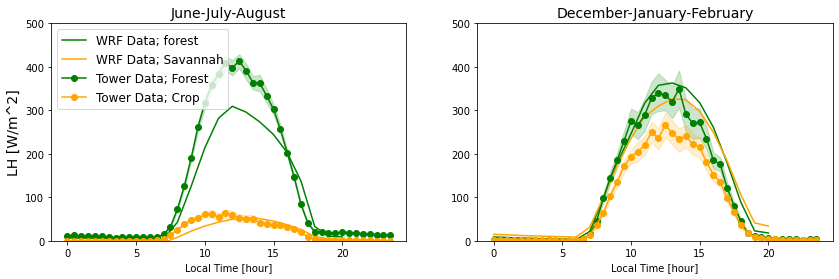

In [6]:
fig,axes = plt.subplots(1,2,figsize=(14,4),sharex=True)
axes = axes.ravel()
axes[0].plot(LH_JJA_forest_areamean[3:],'g',label='WRF Data; forest')
axes[0].plot(LH_JJA_savannah_areamean[3:],'orange',label='WRF Data; Savannah')
axes[0].plot(forest_mn_JJA,'-go',label='Tower Data; Forest')
axes[0].plot(crop_mn_JJA,'-o',color='orange',label='Tower Data; Crop')
axes[0].fill_between(np.arange(0,24,0.5),forest_CI_JJA.left,forest_CI_JJA.right,
                 color='green',alpha=0.2)
axes[0].fill_between(np.arange(0,24,0.5),crop_CI_JJA.left,crop_CI_JJA.right,
                 color='orange',alpha=0.2)

axes[1].plot(LH_JFM_forest_areamean[3:],'g')
axes[1].plot(LH_JFM_savannah_areamean[3:],'orange')
axes[1].plot(forest_mn_JFM,'-go')
axes[1].plot(crop_mn_JFM,'-o',color='orange')
axes[1].fill_between(np.arange(0,24,0.5),forest_CI_JFM.left,forest_CI_JFM.right,
                 color='green',alpha=0.2)
axes[1].fill_between(np.arange(0,24,0.5),crop_CI_JFM.left,crop_CI_JFM.right,
                 color='orange',alpha=0.2)

axes[0].set_title('June-July-August',fontsize=14)
axes[1].set_title('December-January-February',fontsize=14)
axes[0].set_xlabel('Local Time [hour]')
axes[1].set_xlabel('Local Time [hour]')
axes[0].set_ylabel('LH [W/m^2]',fontsize=14)
axes[0].legend(fontsize=12)
axes[0].set_ylim([0,500])
axes[1].set_ylim([0,500])

#fig.savefig('plot_FluxTower_WRF.png',format='png',dpi=600,bbox_inches='tight')